In [1]:
import keras
import tensorflow as tf
import numpy as np

from keras import layers, initializers, ops
from tensorflow.keras.preprocessing.image import array_to_img

import matplotlib.pyplot as plt

In [2]:
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)

n_instances = 10000
dataset = dataset.shuffle(buffer_size=32)
dataset = dataset.map(lambda x: x / 255.0)
dataset = dataset.map(lambda x: (x - 0.5) / 0.5)
dataset = dataset.take(n_instances // 32)

Found 202599 files.


2024-07-31 14:51:09.114136: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-07-31 14:51:09.114167: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-31 14:51:09.114177: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-31 14:51:09.114198: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-31 14:51:09.114209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


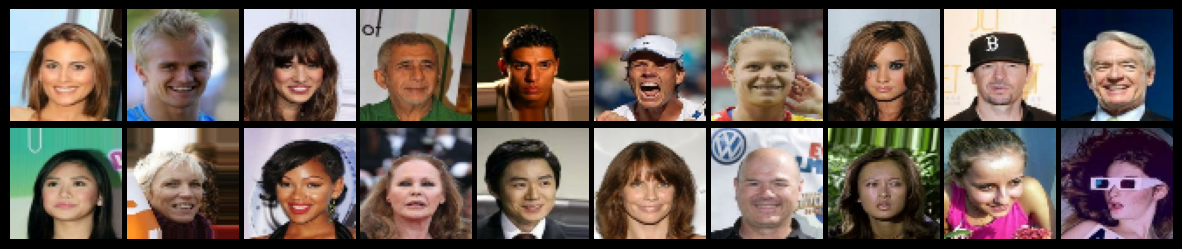

In [3]:
# Create a figure with a black background
fig = plt.figure(figsize=(15, 3))
fig.patch.set_facecolor('black')

# Display 20 images in a grid of 2 rows and 10 columns
for i, batch in enumerate(dataset):
    for j in range(20):
        ax = plt.subplot(2, 10, j + 1)
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        ax.imshow((batch[j].numpy() * 0.5 + 0.5))
    if i >= (20 // 32):
        break

# Adjust layout
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.show()

In [4]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [5]:
latent_dim = 100

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Reshape((1, 1, latent_dim)),
        layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding='valid', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.Activation('tanh'),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 1, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 512)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │         3,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,578,624 (13.65 MB)

 Trainable params: 3,576,704 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [7]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

        # Create random noise for generating images.
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        if epoch in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
            random_latent_vectors = keras.random.normal(
                shape=(self.num_img, self.latent_dim), seed=self.seed_generator
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            for i in range(self.num_img):
                img = keras.utils.array_to_img(generated_images[i])
                img.save("generated_img_%03d_%d.png" % (epoch, i))
    
            # Generate the image from noise.
            g_img = self.model.generator(self.noise)
              
            # Denormalize the image.
            g_img = (g_img * 255)
            g_img.numpy()
        
            fig = plt.figure(figsize = (8,8))
            for i in range(self.num_img):
              plt.subplot(5, 5, i+1)
              img = array_to_img(g_img[i])
              plt.imshow(img)
              plt.axis('off')
              #plt.savefig('/Users/alimahdi/Desktop/Projects/computer_vision/genAI/generated/epoch_{:03d}.png'.format(epoch))
            plt.show()

In [8]:
"""
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

        # Create random noise for generating images.
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

        # Generate the image from noise.
        g_img = self.model.generator(self.noise)
          
        # Denormalize the image.
        g_img = (g_img * 255)
        g_img.numpy()
    
        fig = plt.figure(figsize = (8,8))
        for i in range(self.num_img):
          plt.subplot(5, 5, i+1)
          img = array_to_img(g_img[i])
          plt.imshow(img)
          plt.axis('off')
          #plt.savefig('/Users/alimahdi/Desktop/Projects/computer_vision/genAI/generated/epoch_{:03d}.png'.format(epoch))
        plt.show()
"""

'\nclass GANMonitor(keras.callbacks.Callback):\n    def __init__(self, num_img=3, latent_dim=100):\n        self.num_img = num_img\n        self.latent_dim = latent_dim\n        self.seed_generator = keras.random.SeedGenerator(42)\n\n        # Create random noise for generating images.\n        self.noise = tf.random.normal([25, latent_dim])\n\n    def on_epoch_end(self, epoch, logs=None):\n        random_latent_vectors = keras.random.normal(\n            shape=(self.num_img, self.latent_dim), seed=self.seed_generator\n        )\n        generated_images = self.model.generator(random_latent_vectors)\n        generated_images *= 255\n        generated_images.numpy()\n        for i in range(self.num_img):\n            img = keras.utils.array_to_img(generated_images[i])\n            img.save("generated_img_%03d_%d.png" % (epoch, i))\n\n        # Generate the image from noise.\n        g_img = self.model.generator(self.noise)\n          \n        # Denormalize the image.\n        g_img = (

In [9]:
# Define the custom weight initialization function
def weight_init(model):
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.Conv2DTranspose):
            layer.kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.02)
            if layer.bias is not None:
                layer.bias_initializer = initializers.Zeros()
        elif isinstance(layer, layers.BatchNormalization):
            layer.gamma_initializer = initializers.RandomNormal(mean=1.0, stddev=0.02)
            layer.beta_initializer = initializers.Zeros()

In [10]:
# Initialize weights for generator and discriminator
weight_init(generator)
weight_init(discriminator)

Epoch 1/50


2024-07-31 14:51:10.754261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-07-31 14:51:10.760471: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


312/312 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 0.1463 - g_loss: 179.2286
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 0.3061 - g_loss: 9.1720

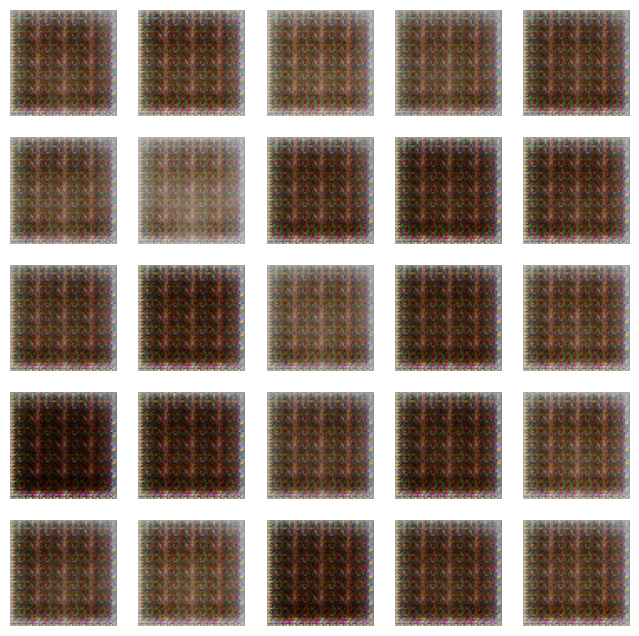

312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.3058 - g_loss: 9.1629
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - d_loss: 0.2342 - g_loss: 5.7859
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - d_loss: 0.2592 - g_loss: 4.5591
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - d_loss: 0.2312 - g_loss: 3.4380
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 0.2872 - g_loss: 3.0376

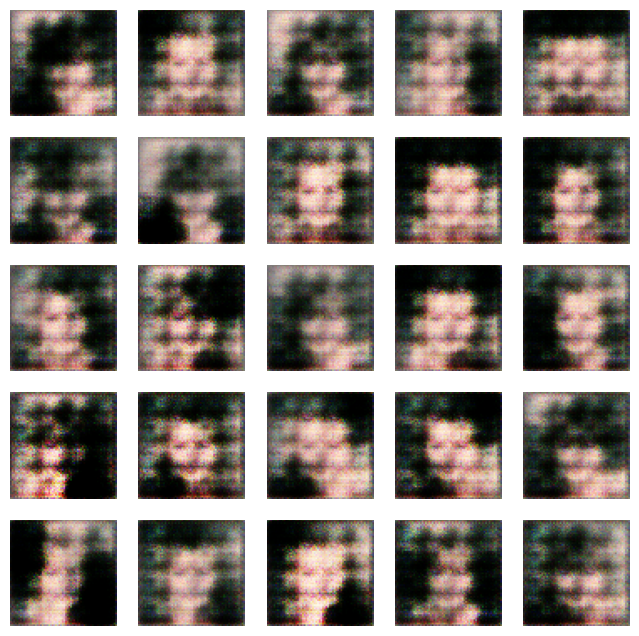

312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - d_loss: 0.2872 - g_loss: 3.0370
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.2969 - g_loss: 2.6240
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - d_loss: 0.3052 - g_loss: 2.6953
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - d_loss: 0.2554 - g_loss: 3.1376
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - d_loss: 0.2890 - g_loss: 2.9354
Epoch 11/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 0.2817 - g_loss: 3.0874

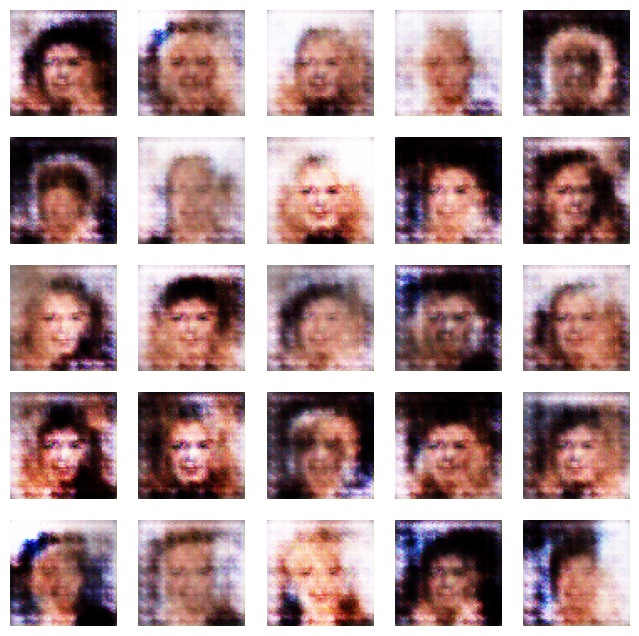

312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - d_loss: 0.2817 - g_loss: 3.0877
Epoch 12/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - d_loss: 0.2824 - g_loss: 3.1105
Epoch 13/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - d_loss: 0.2711 - g_loss: 3.4259
Epoch 14/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - d_loss: 0.2583 - g_loss: 3.4859
Epoch 15/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - d_loss: 0.2700 - g_loss: 3.5155
Epoch 16/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - d_loss: 0.2467 - g_loss: 3.5025

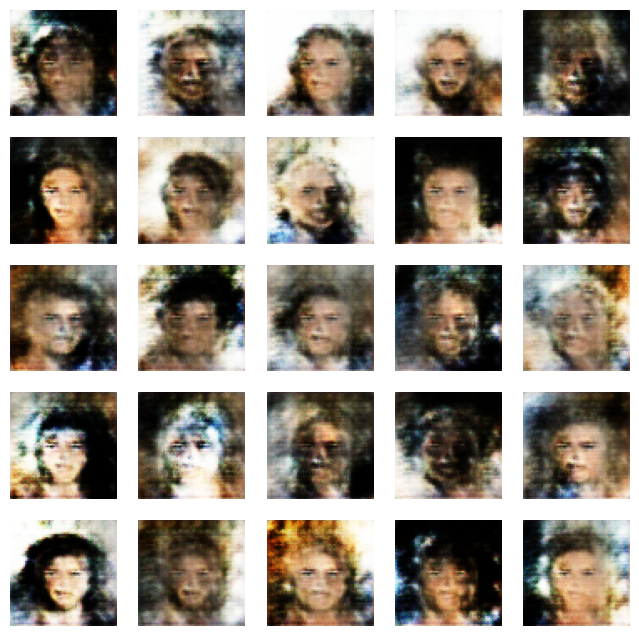

312/312 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - d_loss: 0.2467 - g_loss: 3.5028
Epoch 17/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - d_loss: 0.2282 - g_loss: 3.6196
Epoch 18/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - d_loss: 0.2314 - g_loss: 3.7281
Epoch 19/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - d_loss: 0.2360 - g_loss: 3.7596
Epoch 20/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - d_loss: 0.2122 - g_loss: 4.0276
Epoch 21/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 0.2210 - g_loss: 4.1588

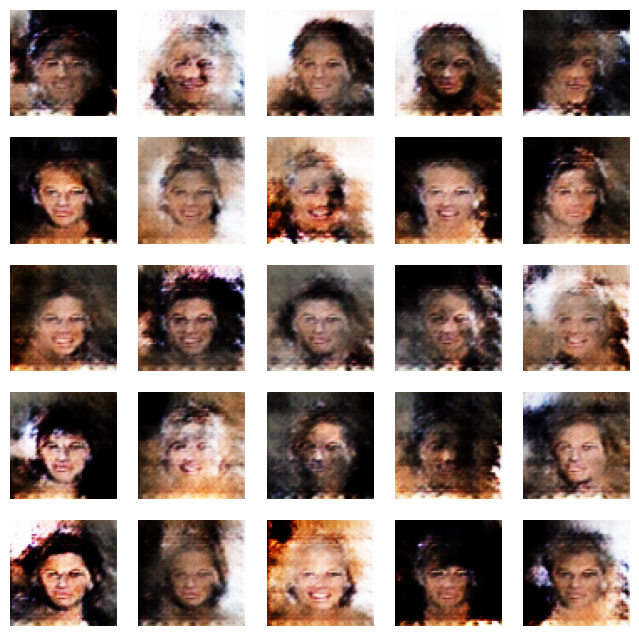

312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - d_loss: 0.2210 - g_loss: 4.1585
Epoch 22/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.1941 - g_loss: 4.2734
Epoch 23/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.1864 - g_loss: 4.2251
Epoch 24/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.1771 - g_loss: 4.5904
Epoch 25/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.1871 - g_loss: 4.6616
Epoch 26/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 0.2346 - g_loss: 4.2540

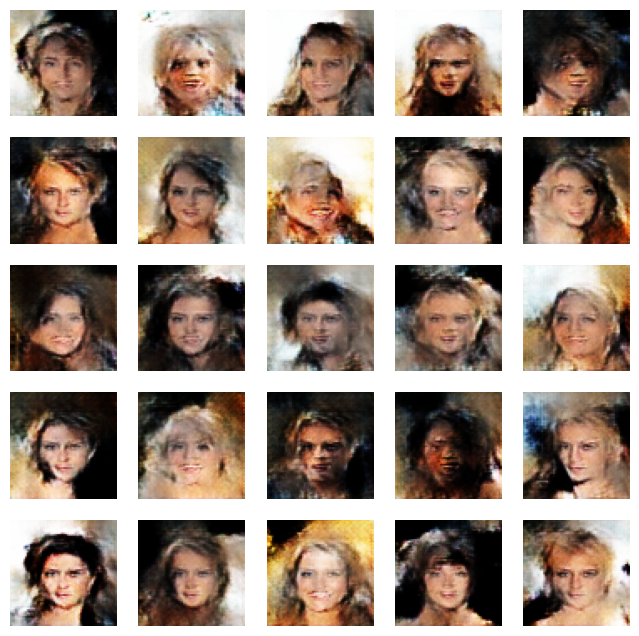

312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - d_loss: 0.2346 - g_loss: 4.2539
Epoch 27/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.1793 - g_loss: 4.3932
Epoch 28/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.1851 - g_loss: 4.2754
Epoch 29/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.1940 - g_loss: 4.3051
Epoch 30/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.2074 - g_loss: 4.4240
Epoch 31/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 0.2384 - g_loss: 4.0703

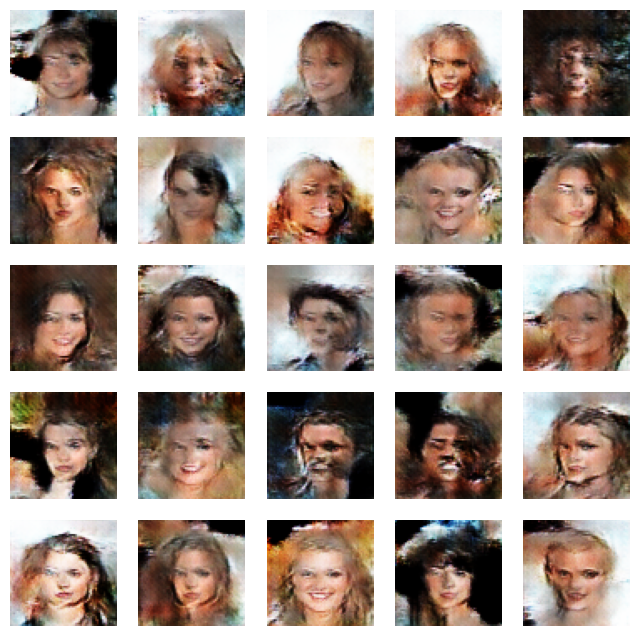

312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - d_loss: 0.2384 - g_loss: 4.0702
Epoch 32/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.2150 - g_loss: 4.1076
Epoch 33/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.2286 - g_loss: 4.0045
Epoch 34/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - d_loss: 0.2126 - g_loss: 3.8830
Epoch 35/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.2335 - g_loss: 3.8353
Epoch 36/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 0.2258 - g_loss: 3.7373

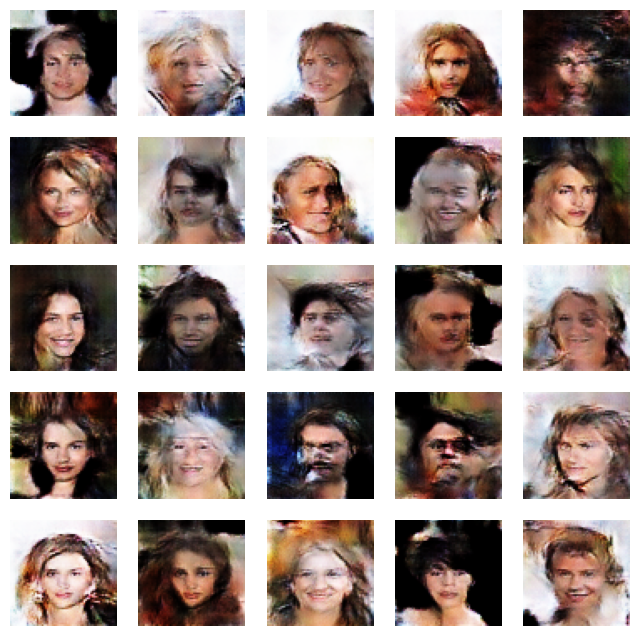

312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - d_loss: 0.2259 - g_loss: 3.7372
Epoch 37/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - d_loss: 0.2383 - g_loss: 3.7382
Epoch 38/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.2506 - g_loss: 3.7251
Epoch 39/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - d_loss: 0.2316 - g_loss: 3.6394
Epoch 40/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - d_loss: 0.2599 - g_loss: 3.5139
Epoch 41/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 0.2403 - g_loss: 3.5601

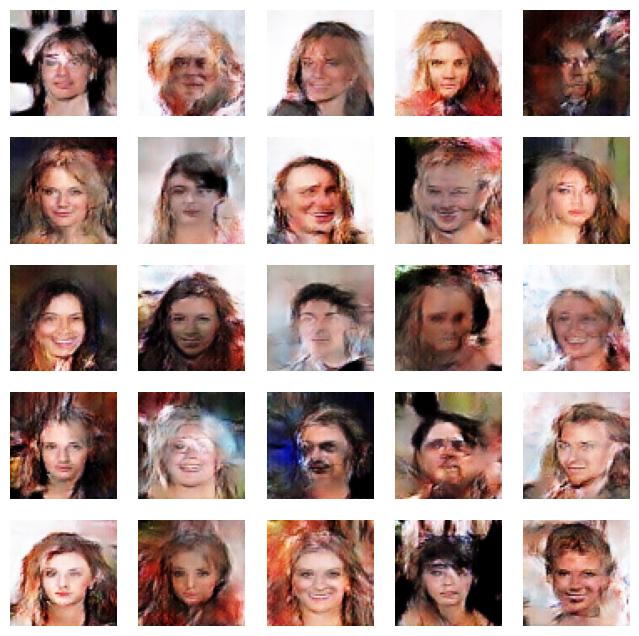

312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - d_loss: 0.2403 - g_loss: 3.5599
Epoch 42/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - d_loss: 0.2508 - g_loss: 3.5700
Epoch 43/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - d_loss: 0.2438 - g_loss: 3.4581
Epoch 44/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - d_loss: 0.2456 - g_loss: 3.5296
Epoch 45/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - d_loss: 0.3870 - g_loss: 3.3166
Epoch 46/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 0.2410 - g_loss: 3.3293

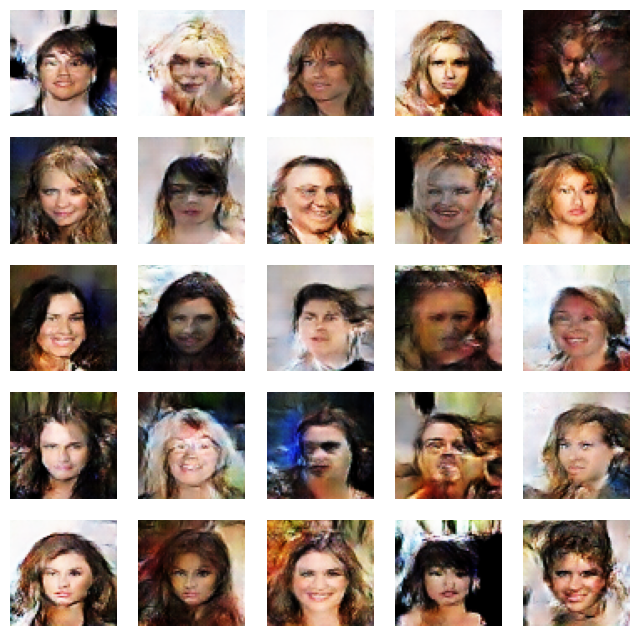

312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - d_loss: 0.2410 - g_loss: 3.3292
Epoch 47/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - d_loss: 0.2449 - g_loss: 3.3409
Epoch 48/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - d_loss: 0.2596 - g_loss: 3.3133
Epoch 49/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - d_loss: 0.2625 - g_loss: 3.2780
Epoch 50/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - d_loss: 0.2397 - g_loss: 3.3288


In [11]:
epochs = 50  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=25, latent_dim=latent_dim)]
)

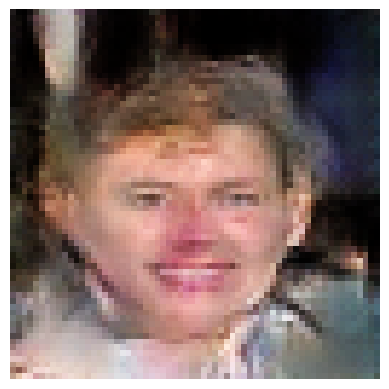

In [12]:
# Create random noise.
noise = tf.random.normal([1, 100])

# Generate image from noise.
g_img = gan.generator(noise)
    
# Denormalize the image.
g_img = (g_img * 255)
g_img.numpy()
img = array_to_img(g_img[0])
plt.imshow(img)
plt.axis('off')
plt.show()

In [13]:
gan.save('dcgan.h5')